In [1]:
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import os
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import DataLoader
import csv
import random
import numpy as np
import cv2
import mimetypes
import fnmatch
import seaborn as sns
from collections import Counter, defaultdict
from torchvision import transforms
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import time
from progress.bar import IncrementalBar
from tqdm.notebook import tqdm_notebook

### Create of a dataset class

In [2]:
labels_map_1 = {
    "Benign": 0,
    "InSitu": 1,
    "Invasive": 2,
}

In [3]:
class ImageDataset(Dataset):
    def __init__(self, annotations_file, paths_file, transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        f = open(paths_file, 'r')
        self.img_paths = f.read().split('\n')
        f.close()
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = read_image(img_path)
        img_folder = int(img_path.split("/")[1])
        label_name = self.img_labels.iloc[img_folder - 1][4]
        label = torch.tensor(labels_map_1[label_name])
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        image = image.float()
        return image, label

In [4]:
f = open('paths.txt', 'r')
img_paths = f.read().split('\n')
f.close()
little_train_paths = np.array(img_paths[0:20000])
f = open('little_train_paths.txt', 'w')
for i in range(little_train_paths.shape[0] - 1):
    f.write(little_train_paths[i] + '\n')  
f.write(little_train_paths[little_train_paths.shape[0] - 1])
f.close()

Feature batch shape: torch.Size([64, 3, 256, 256])
Labels batch shape: 64
torch.Size([256, 256, 3])


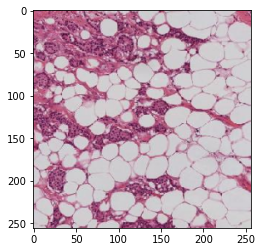

Label: 2


In [5]:
transform = transforms.Resize([256, 256])
little_dataset = ImageDataset('burnasyan_Br.csv', 'little_train_paths.txt', transform = transform)
little_dataloader = DataLoader(little_dataset, batch_size=64, shuffle=True)
features_l, labels_l = next(iter(little_dataloader))
print(f"Feature batch shape: {features_l.size()}")
print(f"Labels batch shape: {len(labels_l)}")
img = features_l[0].squeeze().permute(1, 2, 0).int()
print(img.shape)
label = labels_l[0]
plt.imshow(img)
plt.show()
print(f"Label: {label}")

### Fully connected NN

In [6]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(30*30*3, 512),
            nn.ReLU(),
            nn.Linear(512, 3),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [7]:
device = 'cpu'
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=2700, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=3, bias=True)
  )
)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
# training
for epoch in tqdm_notebook(range(2), desc='net training'):  # loop over the dataset multiple times

    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(little_dataloader, desc='collecting data'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2 == 1:    # print every 2 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2))
            running_loss = 0.0
        i += 1

print('Finished Training')

### Convolutional NN

In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(1014, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = self.fc3(x)
        return x
#     def __init__(self):
#         super().__init__()
#         self.conv1 = nn.Conv2d(3, 6, 5)
#         self.pool = nn.MaxPool2d(2, 2)
#         self.conv2 = nn.Conv2d(6, 16, 5)
#         self.fc1 = nn.Linear(256, 120)
#         self.fc2 = nn.Linear(120, 84)
#         self.fc3 = nn.Linear(84, 3)

#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x)))
#         x = self.pool(F.relu(self.conv2(x)))
#         x = torch.flatten(x, 1) # flatten all dimensions except batch
#         x = F.relu(self.fc1(x))
#         x = F.relu(self.fc2(x))
#         x = self.fc3(x)
#         return x

net = Net()

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in tqdm_notebook(range(2), desc='net training'):  # loop over the dataset multiple times

    running_loss = 0.0
    i = 0
    for data in tqdm_notebook(little_dataloader, desc='collecting data'):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 100 == 99:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0
        i += 1

print('Finished Training')